In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import pandas as pd
import os
import io
import IPython.display
import numpy as np
import PIL.Image
from PIL import Image
from scipy.stats import truncnorm
import tensorflow_hub as hub
import matplotlib.pyplot as plt

import torch
import torchvision.models as models
from torchvision.transforms import (CenterCrop, Compose, Normalize, Resize, ToTensor)
from torchvision.datasets import ImageNet
import csv

In [ ]:
module_path = 'module_128_2'

tf.reset_default_graph()
print('Loading BigGAN module from:', module_path)
module = hub.load(module_path)
signature = module.signatures['default']
inputs = {key: tf.placeholder(dtype=value.dtype, shape=value.shape, name=key)
          for key, value in signature.structured_input_signature[1].items()}
output = signature(**inputs)

print()
print('Inputs:\n', '\n'.join(
    '  {}: {}'.format(*kv) for kv in inputs.items()))
print()
print('Output:', output)

input_z = inputs['z']
input_y = inputs['y']
input_trunc = inputs['truncation']

dim_z = input_z.shape.as_list()[1]
vocab_size = input_y.shape.as_list()[1]


def imgridFromFolder(imarray, cols=5, pad=1):
    if imarray.dtype != np.uint8:
        raise ValueError('imgrid input imarray must be uint8')
    pad = int(pad)
    assert pad >= 0
    cols = int(cols)
    assert cols >= 1
    N, H, W, C = imarray.shape
    rows = N // cols + int(N % cols != 0)
    batch_pad = rows * cols - N
    assert batch_pad >= 0
    post_pad = [batch_pad, pad, pad, 0]
    pad_arg = [[0, p] for p in post_pad]
    imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
    H += pad
    W += pad
    grid = (imarray
            .reshape(rows, cols, H, W, C)
            .transpose(0, 2, 1, 3, 4)
            .reshape(rows*H, cols*W, C))
    if pad:
        grid = grid[:-pad, :-pad]
    return grid

def imshowFromFolder(a, format='png', jpeg_fallback=True):
    a = np.asarray(a, dtype=np.uint8)
    data = io.BytesIO()
    PIL.Image.fromarray(a).save(data, format)
    im_data = data.getvalue()
    try:
        disp = IPython.display.display(IPython.display.Image(im_data))
    except IOError:
        if jpeg_fallback and format != 'jpeg':
            print(('Warning: image was too large to display in format "{}"; '
               'trying jpeg instead.').format(format))
        return imshow(a, format='jpeg')
    else:
        pass
    return disp

def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = PIL.Image.open(os.path.join(folder_path, filename))
        if img is not None:
            images.append(np.array(img))
    return np.array(images)

def truncated_z_sample(batch_size, truncation=1., seed=None):
    state = None if seed is None else np.random.RandomState(seed)
    values = truncnorm.rvs(-2, 2, size=(batch_size, dim_z), random_state=state)
    return truncation * values

def one_hot(index, vocab_size=vocab_size):
    index = np.asarray(index)
    if len(index.shape) == 0:
        index = np.asarray([index])
    assert len(index.shape) == 1
    num = index.shape[0]
    output = np.zeros((num, vocab_size), dtype=np.float32)
    output[np.arange(num), index] = 1
    return output

def one_hot_if_needed(label, vocab_size=vocab_size):
    label = np.asarray(label)
    if len(label.shape) <= 1:
        label = one_hot(label, vocab_size)
    assert len(label.shape) == 2
    return label

def sample(sess, noise, label, truncation=1., batch_size=8,
           vocab_size=vocab_size):
    noise = np.asarray(noise)
    label = np.asarray(label)
    num = noise.shape[0]
    if len(label.shape) == 0:
        label = np.asarray([label] * num)
    if label.shape[0] != num:
        raise ValueError('Got # noise samples ({}) != # label samples ({})'
                         .format(noise.shape[0], label.shape[0]))
    label = one_hot_if_needed(label, vocab_size)
    ims = []
    for batch_start in range(0, num, batch_size):
        s = slice(batch_start, min(num, batch_start + batch_size))
        feed_dict = {input_z: noise[s], input_y: label[s], input_trunc: truncation}
        ims.append(sess.run(output, feed_dict=feed_dict))
    ims = np.concatenate(ims, axis=0)
    assert ims.shape[0] == num
    ims = np.clip(((ims + 1) / 2.0) * 256, 0, 255)
    ims = np.uint8(ims)
    return ims

def interpolate(A, B, num_interps):
    if A.shape != B.shape:
        raise ValueError('A and B must have the same shape to interpolate.')
    alphas = np.linspace(0, 1, num_interps)
    return np.array([(1-a)*A + a*B for a in alphas])

def imgrid(imarray, cols=5, pad=1):
    if imarray.dtype != np.uint8:
        raise ValueError('imgrid input imarray must be uint8')
    pad = int(pad)
    assert pad >= 0
    cols = int(cols)
    assert cols >= 1
    N, H, W, C = imarray.shape
    rows = N // cols + int(N % cols != 0)
    batch_pad = rows * cols - N
    assert batch_pad >= 0
    post_pad = [batch_pad, pad, pad, 0]
    pad_arg = [[0, p] for p in post_pad]
    imarray = np.pad(imarray, pad_arg, 'constant', constant_values=255)
    H += pad
    W += pad
    grid = (imarray
            .reshape(rows, cols, H, W, C)
            .transpose(0, 2, 1, 3, 4)
            .reshape(rows*H, cols*W, C))
    if pad:
        grid = grid[:-pad, :-pad]
    return grid

def imshow(a, format='png', jpeg_fallback=True):
    a = np.asarray(a, dtype=np.uint8)
    data = io.BytesIO()
    PIL.Image.fromarray(a).save(data, format)
    im_data = data.getvalue()
    try:
        disp = IPython.display.display(IPython.display.Image(im_data))
    except IOError:
        if jpeg_fallback and format != 'jpeg':
            print(('Warning: image was too large to display in format "{}"; '
               'trying jpeg instead.').format(format))
        return imshow(a, format='jpeg')
    else:
        pass
    return disp

initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

Loading BigGAN module from: module_128_2

Inputs:
   truncation: Tensor("truncation:0", shape=(), dtype=float32)
  y: Tensor("y:0", shape=(?, 1000), dtype=float32)
  z: Tensor("z:0", shape=(?, 120), dtype=float32)

Output: {'default': <tf.Tensor 'StatefulPartitionedCall_1:0' shape=(?, 128, 128, 3) dtype=float32>}


In [ ]:
from PIL import Image
import os

def resize_images_in_folder(folder_path, target_size=(128, 128)):
    if not os.path.isdir(folder_path):
        raise ValueError(f"The folder path {folder_path} does not exist.")
    for filename in os.listdir(folder_path):
        if filename.endswith(('png', 'jpg', 'jpeg','JPEG')):
            img_path = os.path.join(folder_path, filename)
            with Image.open(img_path) as img:
                img_resized = img.resize(target_size, Image.LANCZOS)
                # Save the resized image as a PNG file
                png_img_path = os.path.splitext(img_path)[0] + ".png"
                img_resized.save(png_img_path, format="PNG")
                print(f"Resized and saved {png_img_path}")



def save_images_as_npz(folder, save_path):
    image_files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('png')]
    all_images = []
    all_labels = []
    for img_path in image_files:
        img = np.array(Image.open(img_path))
        if img.shape[-1] == 4:  # Handle alpha channel if present
            img = img[:, :, :3]
        all_images.append(img)
        # Assuming labels are stored in the filename as image_{label}.png
        label = int(img_path.split('_')[-1].split('.')[0])
        all_labels.append(label)
    imgs = np.array(all_images)
    labels = np.array(all_labels)
    np.savez(save_path, arr_0=imgs, arr_1=labels)


def sample(sess, noise, label, truncation=1., batch_size=8,
           vocab_size=vocab_size):
    noise = np.asarray(noise)
    label = np.asarray(label)
    num = noise.shape[0]
    if len(label.shape) == 0:
        label = np.asarray([label] * num)
    if label.shape[0] != num:
        raise ValueError('Got # noise samples ({}) != # label samples ({})'
                         .format(noise.shape[0], label.shape[0]))
    label = one_hot_if_needed(label, vocab_size)

    # print(f"noise shape: {noise.shape}")
    # print(f"label shape: {label.shape}")
    # print(f"truncation: {truncation}")

    ims = []
    for batch_start in range(0, num, batch_size):
        s = slice(batch_start, min(num, batch_start + batch_size))
        feed_dict = {input_z: noise[s], input_y: label[s], input_trunc: truncation}
        # print(f"Feed dict: {feed_dict}")
        output_dict = sess.run(output, feed_dict=feed_dict)
        ims_batch = output_dict['default']  # Use the appropriate key for the output tensor
        # print(f"ims_batch shape: {ims_batch.shape}")
        ims.append(ims_batch)

    if not ims:
        raise ValueError("No images were generated. Check the model and inputs.")

    ims = np.concatenate(ims, axis=0)
    assert ims.shape[0] == num
    ims = np.clip(((ims + 1) / 2.0) * 256, 0, 255)
    ims = np.uint8(ims)
    return ims

def GAN_1(category:str, num_samples):
    num_samples = num_samples #@param {type:"slider", min:1, max:20, step:1}
    truncation = 0.4 #@param {type:"slider", min:0.02, max:1, step:0.02}
    noise_seed = 0 #@param {type:"slider", min:0, max:100, step:1}

    z = truncated_z_sample(num_samples, truncation, noise_seed)
    y = int(category.split(')')[0])

    # print(f"z shape: {z.shape}")
    # print(f"y: {y}")
    ims = sample(sess, z, y, truncation=truncation)
    os.makedirs('samples/Gan_images', exist_ok=True)

    for i, img_array in enumerate(ims):
        img = Image.fromarray(img_array)
        img.save(f'image_evaluate/Gan_images/{y}/image_{i}.png')

    imgrid_img = imgrid(ims, cols=min(num_samples, 4))

    # Save the generated image grid
    img = Image.fromarray(imgrid_img)
    img.save(f"samples/Gan_images/{y}/image_grid.png")
    imshow(imgrid_img)

# Initialize TensorFlow session
initializer = tf.global_variables_initializer()
sess = tf.Session()
sess.run(initializer)

# Example call to test the function


In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

def resize_image(img, size=(128, 128)):
    return np.array(Image.fromarray(img).resize(size, Image.Resampling.LANCZOS))

def merge_and_save_images(folder, save_path):
    image_files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith(('png', 'jpg', 'jpeg'))]
    image_files = sorted(image_files)[:4]  # Ensure only the first 4 images are taken
    imgs = [mpimg.imread(img_path) for img_path in image_files]
    imgs = [resize_image(np.array(img * 255, dtype=np.uint8) if img.dtype == np.float32 else img) for img in imgs]
    imgrid_img = imgrid(np.array(imgs), cols=4)

    # Save the merged image grid
    img = Image.fromarray(imgrid_img)
    img.save(save_path)

def show_images_from_folders(folder_titles, folder_paths,label_name):
    num_folders = len(folder_paths)
    fig, axes = plt.subplots(num_folders, 1, figsize=(9, num_folders * 3))

    for i, (title, folder) in enumerate(zip(folder_titles, folder_paths)):
        if title == "Gan":
            # Skip merging for Gan, assuming it is already done
            image_files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith(('png'))]
            imgrid_img = mpimg.imread(image_files[0])  # Load the already merged image
        else:
            merge_path = f"samples/{title}_images/{label_name}/merged.png"
            merge_and_save_images(folder, merge_path)
            imgrid_img = mpimg.imread(merge_path)

        ax = axes[i] if num_folders > 1 else axes  # Handle case when num_folders is 1
        ax.imshow(imgrid_img)
        ax.axis('off')
        ax.set_title(title, fontsize=20)

    plt.tight_layout()
    plt.show()

# LABEL: 0


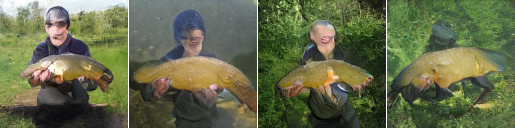

In [ ]:
GAN_1("0",4)
save_images_as_npz('image_evaluate/Gan_images/0','npz_file/gan_128x128_0.npz')

# DIFFUSION MODEL:
attention_resolutions: 32,16,8 ,
num_channels = 256,
num_heads = 4 ,
classifier_scale = 0.5

In [ ]:
!python classifier_sample.py --attention_resolutions 32,16,8 --class_cond True --diffusion_steps 1000 --image_size 128 --learn_sigma True --noise_schedule linear --num_channels 256 --num_heads 4 --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True --classifier_scale 0.5 --classifier_path models/128x128_classifier.pt --model_path models/128x128_diffusion.pt --batch_size 4 --num_samples 4 --timestep_respacing 250 --num_classes 0


Logging to C:\Users\khang\AppData\Local\Temp\openai-2024-06-06-01-25-17-792305
creating model and diffusion...
loading classifier...
sampling...
created 4 samples
saving to npz_file\samples_4x128x128x3_0.5_0.npz
sampling complete


Resized and saved samples/ImageNet_images/0\n01440764_4397.png
Resized and saved samples/ImageNet_images/0\n01440764_4852.png
Resized and saved samples/ImageNet_images/0\n01440764_4965.png
Resized and saved samples/ImageNet_images/0\n01440764_4979.png


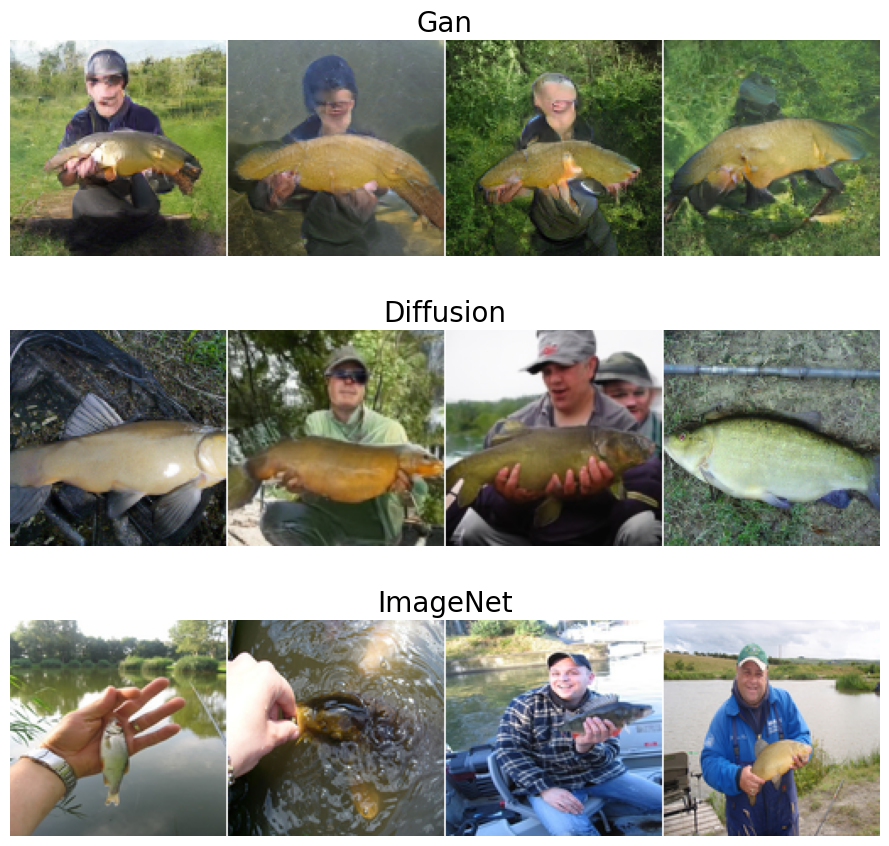

In [ ]:
folder_titles = ["Gan", "Diffusion", "ImageNet"]
folder_paths = ["samples/Gan_images/0", "samples/Diffusion_images/0", "samples/ImageNet_images/0"]

# Show images
resize_images_in_folder('samples/ImageNet_images/0')
save_images_as_npz('samples/ImageNet_images/0','npz_file/Refer_128x128_0.npz')
show_images_from_folders(folder_titles, folder_paths,'0')

In [ ]:
!python evaluations/evaluator.py npz_file/Refer_128x128_10_0.npz npz_file/gan_128x128_10_0.npz

warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 1.31821608543396
FID: 333.939871161022
sFID: 833.1058586487211
Precision: 0.0
Recall: 0.0


2024-06-06 09:42:42.765158: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 09:42:44.026843: W tensorflow/core/framework/op_def_util.cc:369] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().

  0%|          | 0/1 [00:00<?, ?it/s]2024-06-06 09:42:45.355395: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled

100%|██████████| 1/1 [00:23<00:00, 23.83s/it]

100%|██████████| 1/1 [00:01<00:00,  1.50s/it]

100%|██████████| 1/1 [00:06<00:00,  6.16s/it]


In [ ]:
!python evaluations/evaluator.py npz_file/Refer_128x128_10_0.npz npz_file/samples_0.5_0.npz

warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 1.3892922401428223
FID: 143.99456732404272
sFID: 956.2855449485332
Precision: 0.8
Recall: 0.4


2024-06-06 02:57:04.075810: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 02:57:04.516891: W tensorflow/core/framework/op_def_util.cc:369] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().

  0%|          | 0/1 [00:00<?, ?it/s]2024-06-06 02:57:05.316044: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled

100%|██████████| 1/1 [00:03<00:00,  3.89s/it]

100%|██████████| 1/1 [00:01<00:00,  1.17s/it]

100%|██████████| 1/1 [00:01<00:00,  1.08s/it]


In [ ]:
data = {
    "Model": ["Diffuse","GAN"],
    "FID": [143.99456732404272, 333.939871161022],
    "sFID": [956.2855449485332, 833.1058586487211],
    "IS": [1.3892922401428223, 1.31821608543396],
    "Precision": [0.8, 0.0],
    "Recall": [0.4, 0.0]
}

df = pd.DataFrame(data)

# Display the DataFrame
import IPython.display as display
display.display(df)

,Model,FID,sFID,IS,Precision,Recall
0,Diffuse,143.994567,956.285545,1.389292,0.8,0.4
1,GAN,333.939871,833.105859,1.318216,0.0,0.0


# DIFFUSION MODEL:
attention_resolutions: 32,16,8 ,
num_channels = 256,
num_heads = 4 ,
classifier_scale = 0.5

In [ ]:
!python classifier_sample.py --attention_resolutions 32,16,8 --class_cond True --diffusion_steps 1000 --image_size 128 --learn_sigma True --noise_schedule linear --num_channels 256 --num_heads 4 --num_res_blocks 2 --resblock_updown True --use_fp16 True --use_scale_shift_norm True --classifier_scale 0.5 --classifier_path models/128x128_classifier.pt --model_path models/128x128_diffusion.pt --batch_size 4 --num_samples 4 --timestep_respacing 250 --num_classes 174


Logging to C:\Users\khang\AppData\Local\Temp\openai-2024-06-06-01-28-54-391031
creating model and diffusion...
loading classifier...
sampling...
created 4 samples
saving to npz_file\samples_4x128x128x3_0.5_174.npz
sampling complete


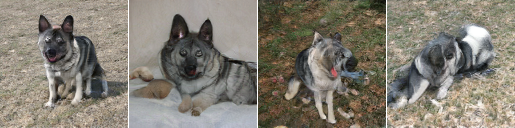

In [ ]:
GAN_1("174",4)
save_images_as_npz('image_evaluate/Gan_images/174','npz_file/gan_128x128_174.npz')

Resized and saved samples/ImageNet_images/174\n02091467_1018.png
Resized and saved samples/ImageNet_images/174\n02091467_1287.png
Resized and saved samples/ImageNet_images/174\n02091467_1549.png
Resized and saved samples/ImageNet_images/174\n02091467_1722.png


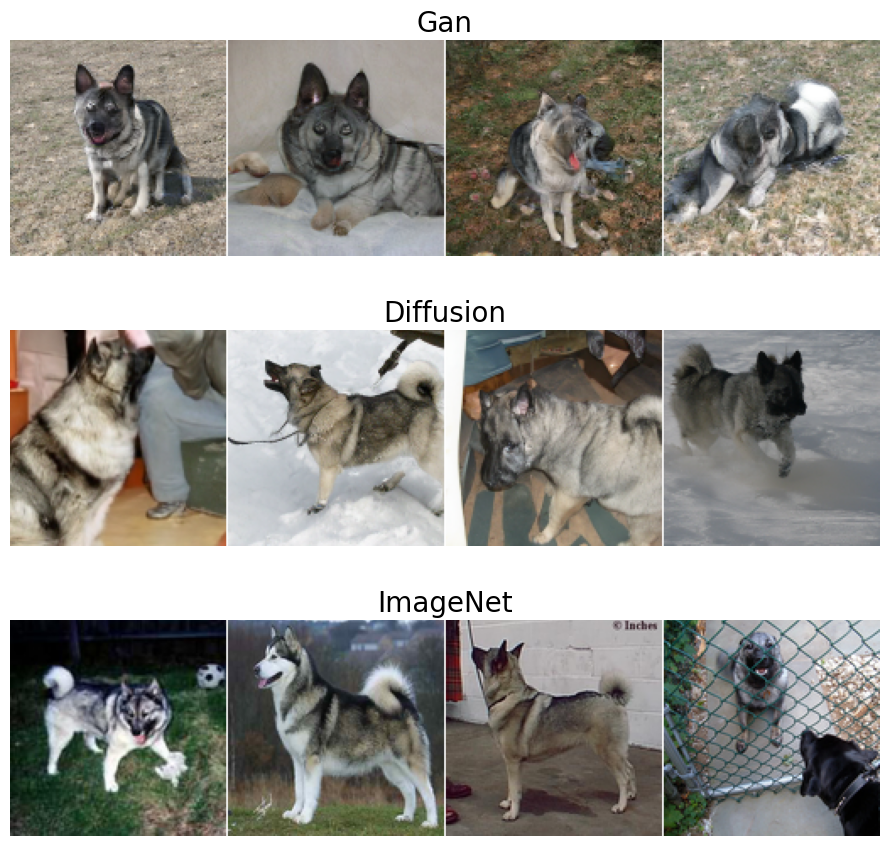

In [ ]:
folder_titles = ["Gan", "Diffusion", "ImageNet"]
folder_paths = ["samples/Gan_images/174", "samples/Diffusion_images/174", "samples/ImageNet_images/174"]

# Show images
resize_images_in_folder('samples/ImageNet_images/174')
save_images_as_npz('samples/ImageNet_images/174','npz_file/Refer_128x128_174.npz')
show_images_from_folders(folder_titles, folder_paths,'174')

In [ ]:
data = {
    "Model": ["Diffuse","GAN"],
    "FID": [163.41639437750456, 172.68720149113955],
    "sFID": [1068.5234583365732, 962.910617509343],
    "IS": [1.0659959316253662, 1.017067551612854],
    "Precision": [1.0, 0.9],
    "Recall": [0.4, 0.1]
}

df = pd.DataFrame(data)

# Display the DataFrame
import IPython.display as display
display.display(df)

,Model,FID,sFID,IS,Precision,Recall
0,Diffuse,163.416394,1068.523458,1.065996,1.0,0.4
1,GAN,172.687201,962.910618,1.017068,0.9,0.1


# Ảnh hưởng của Gradient Scale

In [ ]:
def save_images_as_npz(folder, save_path):
    image_files = [os.path.join(folder, file) for file in os.listdir(folder) if file.endswith('png')]
    all_images = []
    all_labels = []

    for img_path in image_files:
        img = np.array(Image.open(img_path))
        if img.ndim == 2:  # Convert grayscale images to RGB
            img = np.stack((img,)*3, axis=-1)
        all_images.append(img)
        # Assuming labels are stored in the filename as image_{label}.png
        label = int(os.path.basename(img_path).split('_')[-1].split('.')[0])
        all_labels.append(label)

    imgs = np.array(all_images)
    labels = np.array(all_labels)
    np.savez(save_path, arr_0=imgs, arr_1=labels)

In [ ]:
import pandas as pd

# Create a DataFrame
data = {
    "Model(Classifier_Scale)": ["Diffuse(0.5)", "Diffuse(1)", "Diffuse(2)", "Diffuse(4)", "Diffuse(6)", "Diffuse(8)", "Diffuse(10)", "GAN"],
    "FID": [200.1606389011199, 178.41409553789026, 173.00252896207746, 163.41639437750456, 167.01450800767552, 167.84839056376927, 167.6689848991003, 172.68720149113955],
    "sFID": [1024.5188463171728, 1016.4451736473903, 1005.9241977314673, 1068.5234583365732, 1012.5316560075039, 1031.2494169279166, 1072.4947741415938, 962.910617509343],
    "IS": [2.6127688884735107, 1.477493405342102, 1.0236256122589111, 1.0659959316253662, 1.022009015083313, 1.0793757438659668, 1.0371569395065308, 1.017067551612854],
    "Precision": [0.8, 0.9, 0.9, 1.0, 1.0, 0.9, 1.0, 0.9],
    "Recall": [0.7, 0.6, 0.3, 0.4, 0.6, 0.3, 0.5, 0.1]
}

df = pd.DataFrame(data)

# Display the DataFrame
import IPython.display as display
display.display(df)


,Model(Classifier_Scale),FID,sFID,IS,Precision,Recall
0,Diffuse(0.5),200.160639,1024.518846,2.612769,0.8,0.7
1,Diffuse(1),178.414096,1016.445174,1.477493,0.9,0.6
2,Diffuse(2),173.002529,1005.924198,1.023626,0.9,0.3
3,Diffuse(4),163.416394,1068.523458,1.065996,1.0,0.4
4,Diffuse(6),167.014508,1012.531656,1.022009,1.0,0.6
5,Diffuse(8),167.848391,1031.249417,1.079376,0.9,0.3
6,Diffuse(10),167.668985,1072.494774,1.037157,1.0,0.5
7,GAN,172.687201,962.910618,1.017068,0.9,0.1


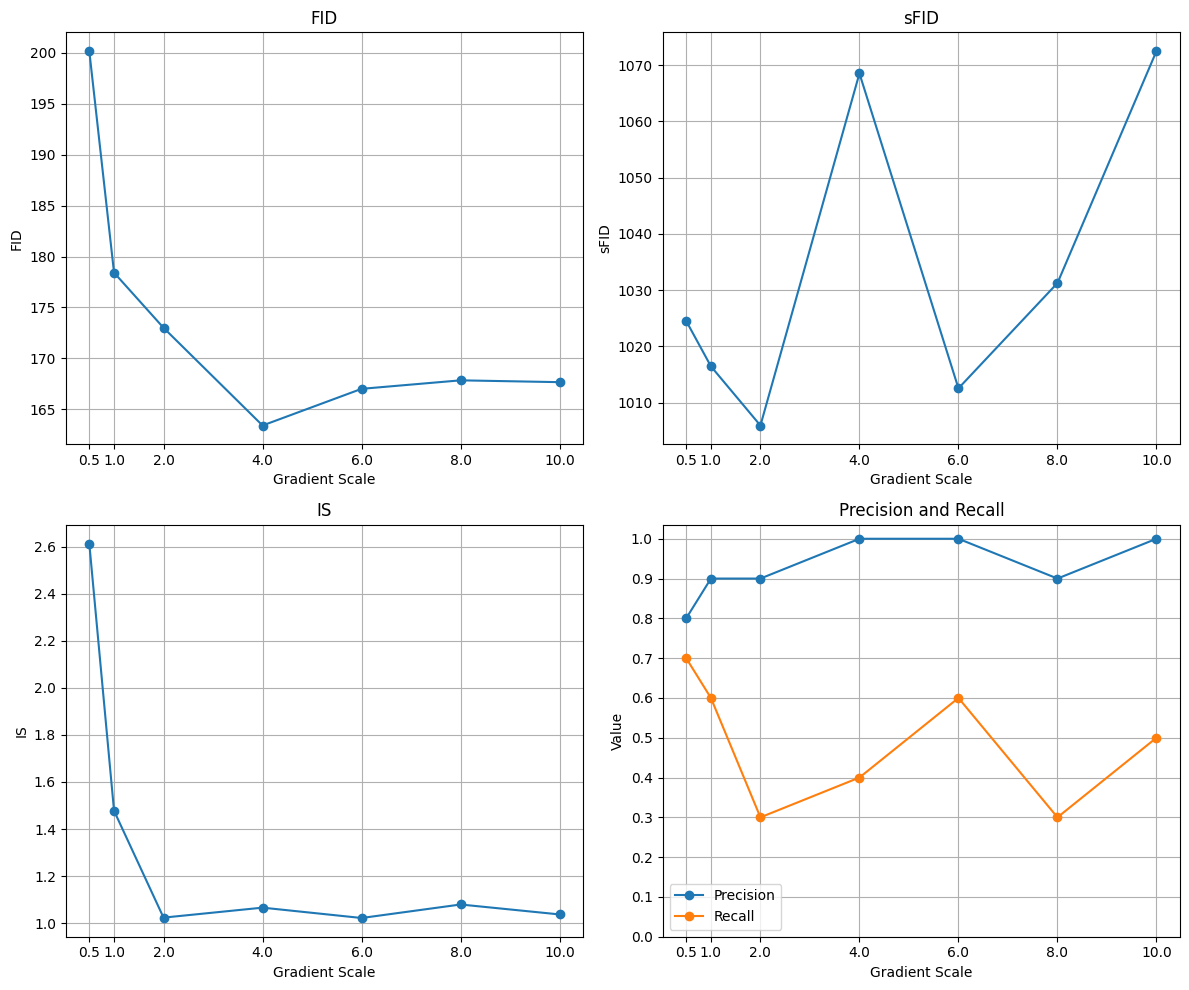

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the data
data = {
    "Classifier_Scale": [0.5, 1, 2, 4, 6, 8, 10],
    "FID": [200.1606389011199, 178.41409553789026, 173.00252896207746, 163.41639437750456, 167.01450800767552, 167.84839056376927, 167.6689848991003],
    "sFID": [1024.5188463171728, 1016.4451736473903, 1005.9241977314673, 1068.5234583365732, 1012.5316560075039, 1031.2494169279166, 1072.4947741415938],
    "IS": [2.6127688884735107, 1.477493405342102, 1.0236256122589111, 1.0659959316253662, 1.022009015083313, 1.0793757438659668, 1.0371569395065308],
    "Precision": [0.8, 0.9, 0.9, 1.0, 1.0, 0.9, 1.0],
    "Recall": [0.7, 0.6, 0.3, 0.4, 0.6, 0.3, 0.5]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Plotting the charts
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# FID chart
axs[0, 0].plot(df["Classifier_Scale"], df["FID"], marker='o')
axs[0, 0].set_title('FID')
axs[0, 0].set_xlabel('Gradient Scale')
axs[0, 0].set_ylabel('FID')
axs[0, 0].set_xticks(df["Classifier_Scale"])
axs[0, 0].grid(True)

# sFID chart
axs[0, 1].plot(df["Classifier_Scale"], df["sFID"], marker='o')
axs[0, 1].set_title('sFID')
axs[0, 1].set_xlabel('Gradient Scale')
axs[0, 1].set_ylabel('sFID')
axs[0, 1].set_xticks(df["Classifier_Scale"])
axs[0, 1].grid(True)

# IS chart
axs[1, 0].plot(df["Classifier_Scale"], df["IS"], marker='o')
axs[1, 0].set_title('IS')
axs[1, 0].set_xlabel('Gradient Scale')
axs[1, 0].set_ylabel('IS')
axs[1, 0].set_xticks(df["Classifier_Scale"])
axs[1, 0].grid(True)

# Precision and Recall chart
axs[1, 1].plot(df["Classifier_Scale"], df["Precision"], marker='o', label='Precision')
axs[1, 1].plot(df["Classifier_Scale"], df["Recall"], marker='o', label='Recall')
axs[1, 1].set_title('Precision and Recall')
axs[1, 1].set_xlabel('Gradient Scale')
axs[1, 1].set_ylabel('Value')
axs[1, 1].set_xticks(df["Classifier_Scale"])
axs[1, 1].set_yticks([i/10 for i in range(11)])
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


# 40 samples

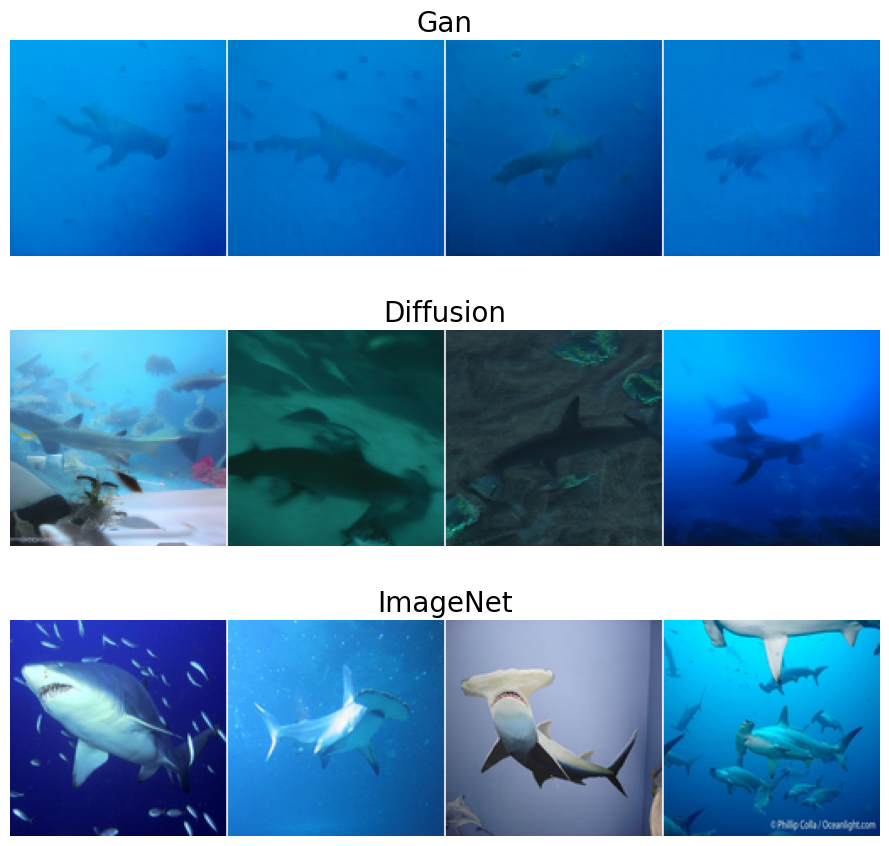

In [ ]:
folder_titles = ["Gan", "Diffusion", "ImageNet"]
folder_paths = ["samples/Gan_images/4", "samples/Diffusion_images/4", "samples/ImageNet_images/4"]

# Show images
show_images_from_folders(folder_titles, folder_paths,'4')

In [ ]:
!python evaluations/evaluator.py npz_file/Refer_128x128_30_4.npz npz_file/samples_0.5_4.npz

warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 1.3497436046600342
FID: 118.51772002272158
sFID: 618.2991814091434
Precision: 0.875
Recall: 0.40540540540540543


2024-06-06 10:43:44.394517: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 10:43:44.938235: W tensorflow/core/framework/op_def_util.cc:369] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().

  0%|          | 0/1 [00:00<?, ?it/s]2024-06-06 10:43:46.178630: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled

100%|██████████| 1/1 [00:05<00:00,  5.69s/it]

100%|██████████| 1/1 [00:04<00:00,  4.14s/it]

100%|██████████| 1/1 [00:04<00:00,  4.57s/it]


In [ ]:
!python evaluations/evaluator.py npz_file/Refer_128x128_30_4.npz npz_file/gan_128x128_40_4.npz

warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 1.31821608543396
FID: 138.93924760773152
sFID: 625.0941356329139
Precision: 0.975
Recall: 0.10810810810810811


2024-06-06 10:44:25.044999: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 10:44:25.498511: W tensorflow/core/framework/op_def_util.cc:369] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().

  0%|          | 0/1 [00:00<?, ?it/s]2024-06-06 10:44:26.311040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled

100%|██████████| 1/1 [00:04<00:00,  4.83s/it]

100%|██████████| 1/1 [00:04<00:00,  4.25s/it]

100%|██████████| 1/1 [00:04<00:00,  4.64s/it]


In [ ]:
data = {
    "Model": ["Diffusion","GAN"],
    "FID": [118.51772002272158, 138.93924760773152],
    "sFID": [618.2991814091434, 625.0941356329139],
    "IS": [1.3497436046600342, 1.31821608543396],
    "Precision": [0.875, 0.975],
    "Recall": [0.40540540540540543, 0.10810810810810811]
}

df = pd.DataFrame(data)

# Display the DataFrame
import IPython.display as display
display.display(df)

,Model,FID,sFID,IS,Precision,Recall
0,Diffusion,118.517720,618.299181,1.349744,0.875,0.405405
1,GAN,138.939248,625.094136,1.318216,0.975,0.108108


# 100 samples

In [ ]:
GAN_1("4",100)
save_images_as_npz('image_evaluate/Gan_images/4','npz_file/gan_128x128_100_4.npz')

In [ ]:
!python evaluations/evaluator.py npz_file/Refer_128x128_100_4.npz npz_file/gan_128x128_100_4.npz

warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 1.376998782157898
FID: 76.66075080222538
sFID: 542.7978801401948
Precision: 0.04
Recall: 0.0


2024-06-06 13:40:55.549600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 13:40:56.259973: W tensorflow/core/framework/op_def_util.cc:369] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().

  0%|          | 0/1 [00:00<?, ?it/s]2024-06-06 13:40:57.396040: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled

100%|██████████| 1/1 [00:05<00:00,  5.39s/it]

  0%|          | 0/2 [00:00<?, ?it/s]2024-06-06 13:41:02.642485: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 181870592 exceeds 10% of free system memory.
2024-06-06 13:41:02.685560: W tenso

In [ ]:
!python evaluations/evaluator.py npz_file/Refer_128x128_100_4.npz npz_file/samples_0.5_4.npz

warming up TensorFlow...
computing reference batch activations...
computing/reading reference batch statistics...
computing sample batch activations...
computing/reading sample batch statistics...
Computing evaluations...
Inception Score: 1.7389198541641235
FID: 69.79111283756137
sFID: 509.76578762909156
Precision: 0.22
Recall: 0.24


2024-06-06 13:41:42.941043: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE SSE2 SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 13:41:43.461152: W tensorflow/core/framework/op_def_util.cc:369] Op BatchNormWithGlobalNormalization is deprecated. It will cease to work in GraphDef version 9. Use tf.nn.batch_normalization().

  0%|          | 0/1 [00:00<?, ?it/s]2024-06-06 13:41:44.378957: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled

100%|██████████| 1/1 [00:04<00:00,  4.45s/it]

  0%|          | 0/2 [00:00<?, ?it/s]2024-06-06 13:41:48.610597: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 181870592 exceeds 10% of free system memory.
2024-06-06 13:41:48.648376: W tenso

In [ ]:
data = {
    "Model": ["Diffusion","GAN"],
    "FID": [69.79111283756137, 76.66075080222538],
    "sFID": [509.76578762909156, 542.7978801401948],
    "IS": [ 1.7389198541641235, 1.376998782157898],
    "Precision": [0.22, 0.04],
    "Recall": [0.24, 0.0]
}

df = pd.DataFrame(data)

# Display the DataFrame
import IPython.display as display
display.display(df)

,Model,FID,sFID,IS,Precision,Recall
0,Diffusion,69.791113,509.765788,1.738920,0.22,0.24
1,GAN,76.660751,542.797880,1.376999,0.04,0.00
